In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
df = pd.read_csv( "../../Training.csv" )
df

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.00,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.00,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.60,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.50,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.50,USD,13357192.5,Closed Lost,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16942,8781,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16943,8786,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q2,2016,NaT,0,EUR,93015.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16944,8792,EMEA,Austria,1,1,1,1,0,Bureaucratic_Code_4,1/15/2016,...,Q1,2016,NaT,0,EUR,103350.00,EUR,299715.0,Closed Won,Prod_Category_A_None
16945,28561,Americas,NE America,1,1,1,1,0,Bureaucratic_Code_4,10/20/2015,...,Q2,2016,NaT,4,USD,2346796.88,USD,0.0,Closed Lost,Prod_Category_A_None


# Tratamiento de datos

In [3]:
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = df['Total_Amount']*0.0096
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = df['Total_Amount']*1.17
df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = df['Total_Amount']*0.70
df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = df['Total_Amount']*1.29
df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'
df.dropna(inplace = True)
df = df[df["Total_Amount"] > 0]
df['Opportunity_Created_Date'] = pd.to_datetime(df['Opportunity_Created_Date'],errors='coerce')
df["Year Created"] = df["Opportunity_Created_Date"].dt.year
df["Month Created"] =df["Opportunity_Created_Date"].dt.month
df["Expensive"] = np.where(df["Total_Amount"] >= 80000, 1, 0)
df['Planned_Delivery_Start_Date'] = pd.to_datetime(df['Planned_Delivery_Start_Date'],errors='coerce')
df['Planned_Delivery_End_Date'] = pd.to_datetime(df['Planned_Delivery_End_Date'],errors='coerce')
df["Total_Amount"] = np.log(df["Total_Amount"])


df["Años en entregar"] = df["Delivery_Year"] - df["Year Created"]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
short_df = df[['Opportunity_ID', "Region", "Años en entregar", 'TRF', "Total_Amount", 'Stage' ]].rename(columns={'Stage': 'Decision'})
short_df = short_df[ (short_df['Decision'] == 'Closed Won') | (short_df['Decision'] == 'Closed Lost') ]
short_df['Decision'] = np.where(short_df['Decision'] == 'Closed Won',1,0)
short_df.set_index('Opportunity_ID', inplace = True)

In [5]:
mean_encoded_reg = short_df.groupby("Region")["Decision"].mean().to_dict()
short_df["Region"] = short_df["Region"].map(mean_encoded_reg)

# Graficos

In [6]:


# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        short_df.drop(columns = 'Decision'),
                                        short_df['Decision'],
                                        random_state = 123,
                                        test_size = 0.3
                                    )

## Grafico funcionamiento Decision Tree

In [7]:
# Importo las librerias necesarias para el grafico
from sklearn import tree
from dtreeviz.trees import *

In [9]:
model = tree.DecisionTreeClassifier(max_depth = 3)
model.fit(X_train, y_train)

viz = dtreeviz(model,
               X_train,
               y_train.values,
               target_name='Stage',
               feature_names=list(X_train.columns),
               class_names=["Closed Won", "Closed Lost"],
               histtype='bar', 
               orientation ='TD')
              
viz.view()


/usr/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 2463 is still running
  ResourceWarning, source=self)


## Grafico varianza Log Loss con n_estimators

In [19]:
key = []
value = []
i = 100
while i <= 1200:
    model = RandomForestRegressor(n_estimators = i)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    loss = log_loss(y_test, preds)
    
    value.append(loss)
    key.append(i)
    i += 100

Text(0.5, 0, 'N_Estimators')

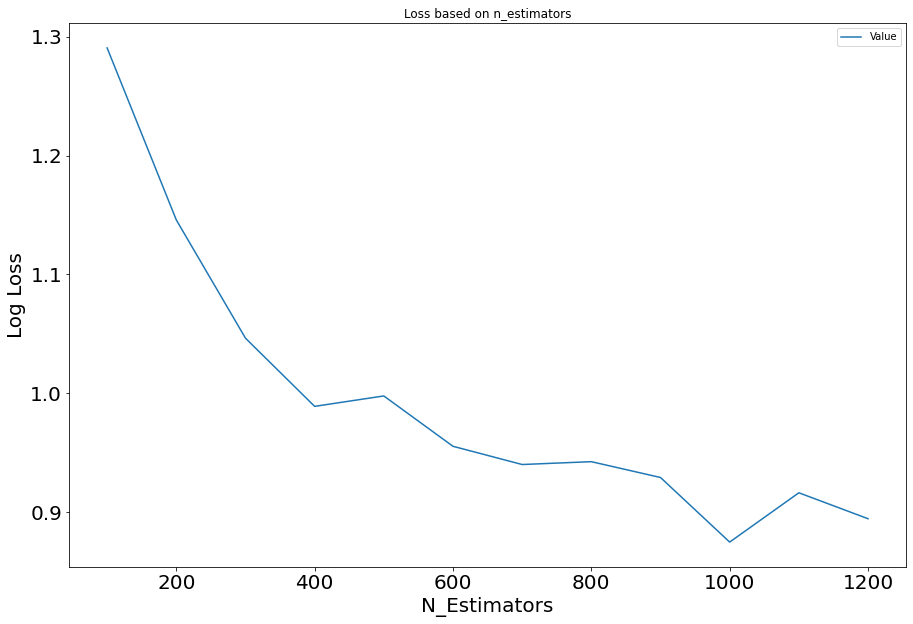

In [20]:
errorPD = pd.DataFrame()
errorPD["Key"] = key
errorPD["Value"] = value
errorPD.set_index("Key", inplace = True)
ax = errorPD.plot(title = "Loss based on n_estimators", figsize = (15, 10), fontsize = 20)
ax.set_ylabel("Log Loss", fontsize = 20)
ax.set_xlabel("N_Estimators", fontsize = 20)

## Feature Importance

Text(0.5, 0, 'Relative Importance')

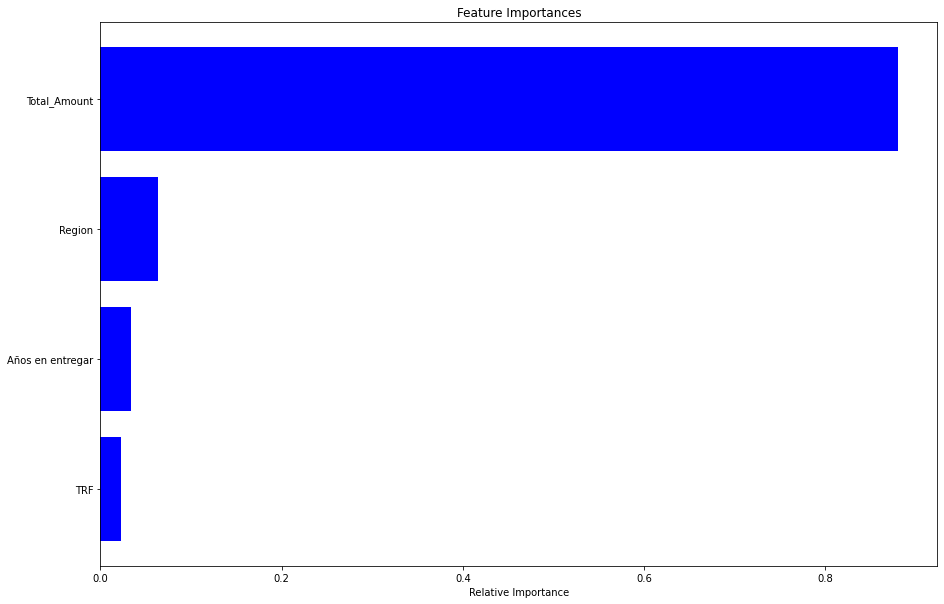

In [21]:
features=short_df.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,10))
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')